# Task 2 - K Nearest Neighbours 

#### Imports

In [1]:
import numpy as np                                              # For general array handling
import pandas as pd                                             # For printing the model metrics in a table
from time import time                                           # To keep track of inference times of the models
import matplotlib.pyplot as plt                                 # To plot the label distribution of the dataset
from sklearn import metrics as sm                               # To calculate the given metrics of the models
from sklearn.neighbors import KNeighborsClassifier as KNN_sk    # KNN model implemented in the sklearn package

## Task 2.1 - Pictionary dataset

#### Loading the data and discarding unnecessary columns

In [2]:
data = np.load("data.npy", allow_pickle=True)
data = data[:, 1:4] # Removing the guess time column and the data IDs

## Task 2.2 - Exploratory Data Analysis

### Task 2.2.1 - Plotting the label distribution across various data points

#### Preparing the distribution of the labels in the dataset

In [3]:
data_labels = data[:, -1]   # To get the labels of all the data points
label_frequency = {}        # Dictionary to keep track of frequencies of all labels
for label in data_labels:
    if label in label_frequency:
        label_frequency[label] += 1
    else:
        label_frequency[label] = 1

# Sorting the labels by their frequencies
label_frequency = dict(sorted(label_frequency.items(), key= lambda x: x[1]))

#### Plotting the distribution

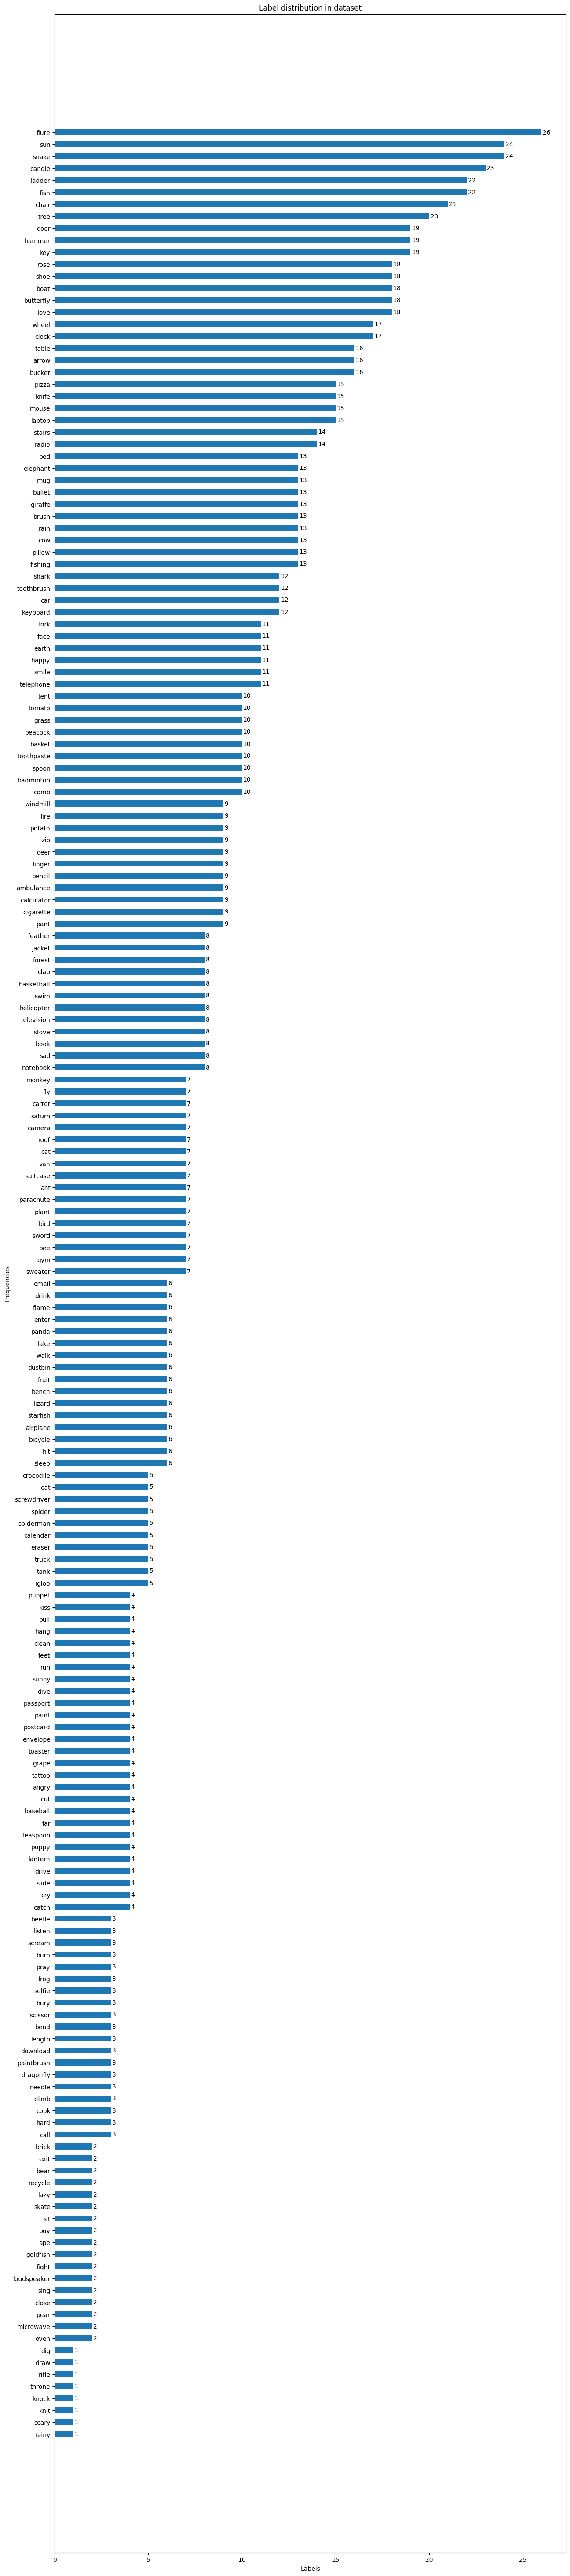

In [4]:
labels = list(label_frequency.keys())
freqs = list(label_frequency.values())

fig, ax = plt.subplots(figsize=(15, 75))    # To handle the many number of labels when plotted on a horizontal bar graph

# The lists have been reversed to print the frequencies in descending order
plot = ax.barh(labels, freqs, height=0.5)   # Height set to 0.5 to reduce the thickness of the bars
ax.bar_label(plot, labels=freqs, padding=2) # Setting the labels of the bars to the frequencies

plt.xlabel("Labels")
plt.ylabel("Frequencies")
plt.title("Label distribution in dataset")
plt.show()

## Task 2.3 - KNN Implementation

#### Train-validation split

In [5]:
np.random.shuffle(data) # Shuffle the data points

train_validation_split = 0.8    # 80-20 train validation split of the dataset
train_data_len = int(train_validation_split * data.shape[0])

train_data = data[:train_data_len]      # First 80% of the shuffled dataset
validation_data = data[train_data_len:] # Last  20% of the shuffled dataset

#### Class to encapsulate all distance calculation methods between all train data points and the test data point

In [6]:
# This class implements all the three distance metrics given
class DistMetric():
    def __init__(self):
        pass

    # In all these functions, axis=1 has been used in the norm function to calculate norm of each column of the train_encoding matrix
    # as each column of the matrix will be one encoding of a data point. So, the norm of each column will be the distance between the
    # train data point and the test data point
    
    # By default, norm is computed with order 2
    def __euclidean(self, train_encoding, test_encoding) -> float:
        return np.linalg.norm(train_encoding - test_encoding, axis=1)

    # Manhattan distance is computed with order 1
    def __manhattan(self, train_encoding, test_encoding) -> float:
        return np.linalg.norm(train_encoding - test_encoding, axis=1, ord=1)
    
    # np.dot computes dot product of every train encoding with the single test encoding
    def __cosine(self, train_encoding, test_encoding) -> float:
        return 1 - (np.dot(train_encoding, test_encoding) / (np.linalg.norm(train_encoding, axis=1) * np.linalg.norm(test_encoding)))
    
    def calcDist(self, train_encoding, test_encoding, metric_type='Euclidean') -> float:
        if metric_type.lower() == 'euclidean':
            return self.__euclidean(train_encoding, test_encoding)
        elif metric_type.lower() == 'manhattan':
            return self.__manhattan(train_encoding, test_encoding)
        elif metric_type.lower() == 'cosine':
            return self.__cosine(train_encoding, test_encoding)
        else:
            raise ValueError(f'{metric_type} is not a valid distance metric')

### Task 2.3.1.1 - KNN Class

#### Initial KNN class

## Assumption in KNN implementation:
- Test data will be of same format as the provided `data.npy` file

In [7]:
# Un-vectorized KNN class which is slow due to the use of dictionaries and not using the in-built functions of numpy
class KNN_initial(DistMetric):
    # Initialisation method
    def __init__(self, encoder='ResNet', k=3, dist_metric='Euclidean'):
        self.encoder = encoder
        self.k = k
        self.dist_metric = dist_metric
        self.train_data_dict = {}   # Dictionary to keep track of encodings of various points to their labels
        self.__train()

    # Training method
    def __train(self):
        if self.encoder.lower() == 'resnet':
            self.train_data_dict = {tuple(i[0][0]): i[2] for i in train_data}   # i[0][0] is chosen as i[0] also contains the data type of the object
                                                                                # due to numpy array initialisations
        elif self.encoder.lower() == 'vit':
            self.train_data_dict = {tuple(i[1][0]): i[2] for i in train_data}   # Mapping the tuple of the encoding of the point to its label

    # Validation method
    def inference(self, data) -> str:
        if self.encoder.lower() == 'resnet':
            test_encoding = data[0][0]         # 1st column of data points is the ResNet encoding
        elif self.encoder.lower() == 'vit':
            test_encoding = data[1][0]         # 2nd column of data points is the VIT encoding
        train_encoding = list(map(list, self.train_data_dict.keys()))   # List of all encodings after converting them to lists from tuples

        dist_list = DistMetric().calcDist(train_encoding, test_encoding, self.dist_metric)  # List of distances between all records in the train dataset and the test data point
        
        dist_label_dict = dict(zip(dist_list, list(self.train_data_dict.values()))) # Dictionary with distance between train and test data point as key and corresponding label of train data point as value
        dist_label_dict = dict(sorted(dist_label_dict.items()))                     # Sorting the entries of this dictionary based on ascending order of distances

        label_list = list(dist_label_dict.values())[:self.k]    # First k labels are chosen are they are the k nearest neighbours to the data point
        label_freq_dict = {}                                    # Dictionary to store frequencies of each label to return the inference and break ties if needed
        for label in label_list:
            if label in label_freq_dict:
                label_freq_dict[label] += 1
            else:
                label_freq_dict[label] = 1

        # First sort the labels in descending order of frequency of occurrence and then sort the labels in alphabetical order and choose the first label
        label_freq_dict = dict(sorted(label_freq_dict.items(), key= lambda item: (-item[1], item[0])))

        return list(label_freq_dict.keys())[0]  # First label in the list of sorted labels

### Code by ChatGPT

- In the above code, I have used the following prompt in ChatGPT to sort `label_freq_dict`:<br/><br/>
    **I have a dictionary with words as keys and their frequencies as the values in a python dictionary. I want to sort the dictionary in such a way that they are ordered in descending order of the frequencies, i.e., values and the ties are broken by ordering the words, i.e., keys in ascending order**

- It gave this output:<br/>
    ```py
    word_freq = {
        'apple': 5,
        'banana': 3,
        'cherry': 5,
        'date': 2,
        'grape': 4
    }

    sorted_word_freq = sorted(word_freq.items(), key=lambda item: (-item[1], item[0]))

    sorted_dict = dict(sorted_word_freq)
    print(sorted_dict)
    ```

#### Helper function to print metrics

In [8]:
# Function to print the metrics in a table format
def printMetrics(metrics_values):
    metrics_list = ['Accuracy', 'Macro F-1 score', 'Micro F-1 score', 'Weighted F-1 score', 'Precision', 'Recall']
    table_list = []

    for i in range(len(metrics_list)):
        table_list.append([metrics_list[i], metrics_values[i]])

    # Printing the metrics in a table format after removing the index column
    df = pd.DataFrame(table_list, columns=['Metric', 'Value'])
    display(df.style.hide(axis='index'))

### Task 2.3.1.2 - Performing inference on the dataset

In [9]:
model = KNN_initial(encoder='VIT')
inference_list_initial = [model.inference(i) for i in validation_data]

### Task 2.3.1.3 - Printing metrics of the model based on the inference done

In [10]:
accuracy          = sm.accuracy_score( validation_data[:, 2], inference_list_initial)
macro_f1_score    = sm.f1_score(       validation_data[:, 2], inference_list_initial, average='macro')
micro_f1_score    = sm.f1_score(       validation_data[:, 2], inference_list_initial, average='micro')
weighted_f1_score = sm.f1_score(       validation_data[:, 2], inference_list_initial, average='weighted')
precision         = sm.precision_score(validation_data[:, 2], inference_list_initial, average='macro', zero_division=0)
recall            = sm.recall_score(   validation_data[:, 2], inference_list_initial, average='macro', zero_division=0)

metrics_values = [accuracy, macro_f1_score, micro_f1_score, weighted_f1_score, precision, recall]
printMetrics(metrics_values)

Metric,Value
Accuracy,0.200000
Macro F-1 score,0.121311
Micro F-1 score,0.200000
Weighted F-1 score,0.189470
Precision,0.132268
Recall,0.133229


#### Modifying data for faster access

In [11]:
train_resnet_data = np.array([i[0] for i in train_data[:, 0]])  # Extracting the inner encoding from the list of list form
train_vit_data    = np.array([i[0] for i in train_data[:, 1]])  # of every encoding element in the dataset
train_labels      = np.array([i for i in train_data[:, 2]])

validation_resnet_data = np.array([i[0] for i in validation_data[:, 0]])  # Extracting the inner encoding from the list of list form
validation_vit_data    = np.array([i[0] for i in validation_data[:, 1]])  # of every encoding element in the dataset

resnet_data = np.concatenate((train_resnet_data, validation_resnet_data), axis=0)  # Obtaining the encodings of the entire dataset
vit_data    = np.concatenate((train_vit_data,       validation_vit_data), axis=0)  # by concatenating the train and validation encodings

### Task 2.3.1.1 - KNN Class

#### Optimised KNN class

## Assumption in KNN implementation:
- Test data will be of same format as the provided `data.npy` file

In [12]:
# This implementation considerably speeds up after using np methods to keep track of sorting between labels and distances
# and also in finding the k nearest neighbours
class KNN(DistMetric):
    # Initialisation method
    def __init__(self, encoder='ResNet', k=3, dist_metric='Euclidean'):
        self.encoder              =  encoder
        self.k                    =  k
        self.dist_metric          =  dist_metric
        self.train_encodings      =  []   # List to keep track of encodings of all train data points
        self.validation_encodings =  []   # List to keep track of encodings of all validation data points
        self.test_encoding        =  []   # List to keep track of encoding of the given test data point
        self.train_labels         =  []   # List to keep track of labels of all train data points 
        
        self.__train()

    # Training method
    def __train(self):
        if self.encoder.lower()   == 'resnet':
            self.train_encodings   = train_resnet_data
        elif self.encoder.lower() == 'vit':
            self.train_encodings   = train_vit_data
        self.train_labels          = train_labels

    # Method predicts the appropriate label for the given data point
    def __predict(self, data) -> str:
        dist_list = DistMetric().calcDist(self.train_encodings, data, self.dist_metric)  # List of distances between all records in the train dataset and the test data point
        
        dist_indices = np.argsort(dist_list)                            # Returns a list of the indices where the distances have been placed after sorting
        k_nearest_labels = self.train_labels[dist_indices][:self.k]     # Extracting the labels ordered using the above indices and then selecting the first k labels

        labels, freqs = np.unique(k_nearest_labels, return_counts=True) # Returns the unique labels and their frequencies in the k nearest labels
        return labels[np.argmax(freqs)]                                 # Returns the index in the list which has the highest frequency which is then used to find the corresponding label

    # Method predicts labels for the entire validation split
    def inference(self) -> list:
        if self.encoder.lower()        == 'resnet':
            self.validation_encodings   = validation_resnet_data
        elif self.encoder.lower()      == 'vit':
            self.validation_encodings   = validation_vit_data

        validation_labels = [self.__predict(i) for i in self.validation_encodings]
        return validation_labels
    
    # Public method to predict the label of the given test data point
    def predict(self, data) -> str:
        if self.encoder.lower()   == 'resnet':
            self.test_encoding     = data[1][0] # Assuming the data is given directly as seen in the unfiltered `data.npy` file,
        elif self.encoder.lower() == 'vit':
            self.test_encoding     = data[2][0] # the encodings are extracted from the appropriate columns

        return self.__predict(self.test_encoding)

### Code by ChatGPT

- To get the labels sorted in the same order as the distances and then choose the label with the highest frequency from the k nearest labels, I used the following ChatGPT prompt:<br/><br/>
  **I have a python numpy array containing distances of float data type and another numpy array containing labels of string data type in the corresponding elements. I want to sort these labels in the same order as the distances and then from the first k labels, I want the label which appears the most. I want an optimised code using in-built numpy functions**

- It gave the following output:
  ```py
  import numpy as np

  # Example data: distances and labels
  distances = np.array([0.5, 0.2, 0.8, 0.3, 0.9])
  labels = np.array(['cat', 'dog', 'dog', 'cat', 'bird'])

  k = 3  # Number of nearest neighbors

  # Sort distances and labels together based on distances
  sorted_indices = np.argsort(distances)
  sorted_labels = labels[sorted_indices]

  # Find the unique labels and their counts in the top k neighbors
  unique_labels, counts = np.unique(sorted_labels[:k], return_counts=True)

  # Find the label that appears the most among the top k distances
  most_common_label = unique_labels[np.argmax(counts)]

  print("Most common label:", most_common_label)
  ```

### Task 2.3.1.2 - Performing inference

In [13]:
model2 = KNN(encoder='VIT', k=5, dist_metric='Euclidean')
inference_list = model2.inference()

### Task 2.3.1.3 - Printing metrics of the model based on the inference done

In [14]:
accuracy          = sm.accuracy_score( validation_data[:, 2], inference_list)
macro_f1_score    = sm.f1_score(       validation_data[:, 2], inference_list, average='macro')
micro_f1_score    = sm.f1_score(       validation_data[:, 2], inference_list, average='micro')
weighted_f1_score = sm.f1_score(       validation_data[:, 2], inference_list, average='weighted')
precision         = sm.precision_score(validation_data[:, 2], inference_list, average='macro', zero_division=0)
recall            = sm.recall_score(   validation_data[:, 2], inference_list, average='macro', zero_division=0)

metrics_values = [accuracy, macro_f1_score, micro_f1_score, weighted_f1_score, precision, recall]
printMetrics(metrics_values)

Metric,Value
Accuracy,0.223333
Macro F-1 score,0.138619
Micro F-1 score,0.223333
Weighted F-1 score,0.206998
Precision,0.154255
Recall,0.151440


## Task 2.4 - Hyperparameter Tuning

### Tasks 2.4.1.1 and 2.4.1.2 - Best (k, encoder, distance metric) triplets that give highest accuracy and printing top 20 such triplets

#### Iterating over all feasible triplets and keeping track of their scores

In [15]:
k_range = list(range(1, int(np.sqrt(len(data))) + 11))    # A feasible limit of k is sqrt(N) where N is the size of the entire dataset. 10 more values of k are also considered 
encoders = ['VIT', 'ResNet']
dist_metric = ['Manhattan', 'Euclidean', 'Cosine']
params = []

for k in k_range:
    for encoder in encoders:
        for metric in dist_metric:
            param_model = KNN(encoder=encoder, k=k, dist_metric=metric)

            # Inference time is also kept track to find out the most optimised model, which is required for further tasks as well
            start_inference         = time()
            param_predicted_labels  = param_model.inference()
            end_inference           = time()
            
            acc = sm.accuracy_score(validation_data[:, 2], param_predicted_labels)
            
            params.append(tuple([acc, k, encoder, metric, end_inference - start_inference]))

## Assumption in tiebreaking for best and most optimised hyperparamters:
- ### Best hyperparameters:
  - First sorted in decreasing order of `Accuracy`
  - In case of ties, sorting is done in ascending order of `Inference Time`
<br/><br/>

- ### Most optimised hyperparameters:
  - First sorted in ascending order of `Inference Time`
  - In case of ties, sorting is done in descending order of `Accuracy`

In [16]:
# Sort the triplets based on descending order of accuracy and then ascending order of inference time
# -ve sign to handle ascending order of inference time
accuracy_sorted_params = sorted(params, reverse=True, key=lambda x: (x[0], -x[4]))

# Similarly, the triplets are sorted based on ascending order of inference time and then descending order of accuracy
time_sorted_params = sorted(params, key=lambda x: (x[4], -x[0]))

# Best and the most optimised paramteres are the first elements in these sorted lists
best_params = [accuracy_sorted_params[0][1], accuracy_sorted_params[0][2], accuracy_sorted_params[0][3]]
optimised_params = [time_sorted_params[0][1], time_sorted_params[0][2], time_sorted_params[0][3]]

print('Best parameters          :', best_params)
print('Most optimised parameters:', optimised_params)
print(accuracy_sorted_params[:20])

Best parameters          : [14, 'VIT', 'Manhattan']
Most optimised parameters: [4, 'VIT', 'Cosine']
[(0.23666666666666666, 14, 'VIT', 'Manhattan', 0.4201188087463379), (0.23666666666666666, 16, 'VIT', 'Manhattan', 0.4224860668182373), (0.23666666666666666, 17, 'VIT', 'Manhattan', 0.4347963333129883), (0.23666666666666666, 11, 'VIT', 'Manhattan', 0.48548197746276855), (0.23333333333333334, 18, 'VIT', 'Manhattan', 0.4218745231628418), (0.23333333333333334, 12, 'VIT', 'Manhattan', 0.4303121566772461), (0.23, 15, 'VIT', 'Manhattan', 0.421985387802124), (0.23, 20, 'VIT', 'Manhattan', 0.43301844596862793), (0.23, 13, 'VIT', 'Manhattan', 0.4389827251434326), (0.23, 19, 'VIT', 'Manhattan', 0.4441676139831543), (0.23, 10, 'VIT', 'Manhattan', 0.6105468273162842), (0.22666666666666666, 5, 'VIT', 'Manhattan', 0.4653048515319824), (0.22666666666666666, 7, 'ResNet', 'Manhattan', 0.7590434551239014), (0.22666666666666666, 10, 'ResNet', 'Manhattan', 0.951331615447998), (0.22333333333333333, 5, 'VIT', 

### Task 2.4.1.3 - k vs accuracy plot with VIT encoder and Euclidean distance metric

### Calculation of accuracies

In [17]:
accuracies = []

# Iterating over all the feasible values of k as initialised in a previous cell
for k in k_range:
    param_model = KNN(encoder='VIT', k=k, dist_metric='Euclidean')
    param_predicted_labels = param_model.inference()

    # Calculating the accuracy of the model initialised with the given k value        
    acc = sm.accuracy_score(validation_data[:, 2], param_predicted_labels)
    accuracies.append(acc)

#### Plotting k vs accuracy

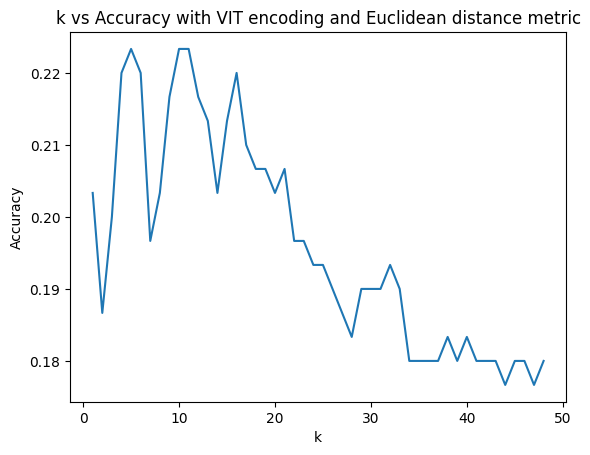

In [18]:
plt.plot(k_range, accuracies)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k vs Accuracy with VIT encoding and Euclidean distance metric')
plt.show()

## Task 2.6 - Optimization

### Task 2.6.1.2 - Inference time for each of the 4 models on the 80-20 train-validation split

In [19]:
# Model initialisations
initial   = KNN_initial(encoder='VIT', k=5, dist_metric='Manhattan')
best      = KNN(encoder=best_params[1], k=best_params[0], dist_metric=best_params[2])
optimised = KNN(encoder=optimised_params[1], k=optimised_params[0], dist_metric=optimised_params[2])
default =  KNN_sk()
default.fit(train_vit_data, train_labels)

initial_inference_time, best_inference_time, optimised_inference_time, default_inference_time = 0, 0, 0, 0

# Initial model
inference_start = time()
initial_preds = [initial.inference(i) for i in validation_data]
inference_end = time()
initial_inference_time = inference_end - inference_start

# Best model
inference_start = time()
best_preds = best.inference()
inference_end = time()
best_inference_time = inference_end - inference_start

# Most optimised model
inference_start = time()
optimised_preds = optimised.inference()
inference_end = time()
optimised_inference_time = inference_end - inference_start

# Default sklearn model
inference_start = time()
default_preds = default.predict(validation_vit_data)
inference_end = time()
default_inference_time = inference_end - inference_start

#### Plot of the inference time vs model

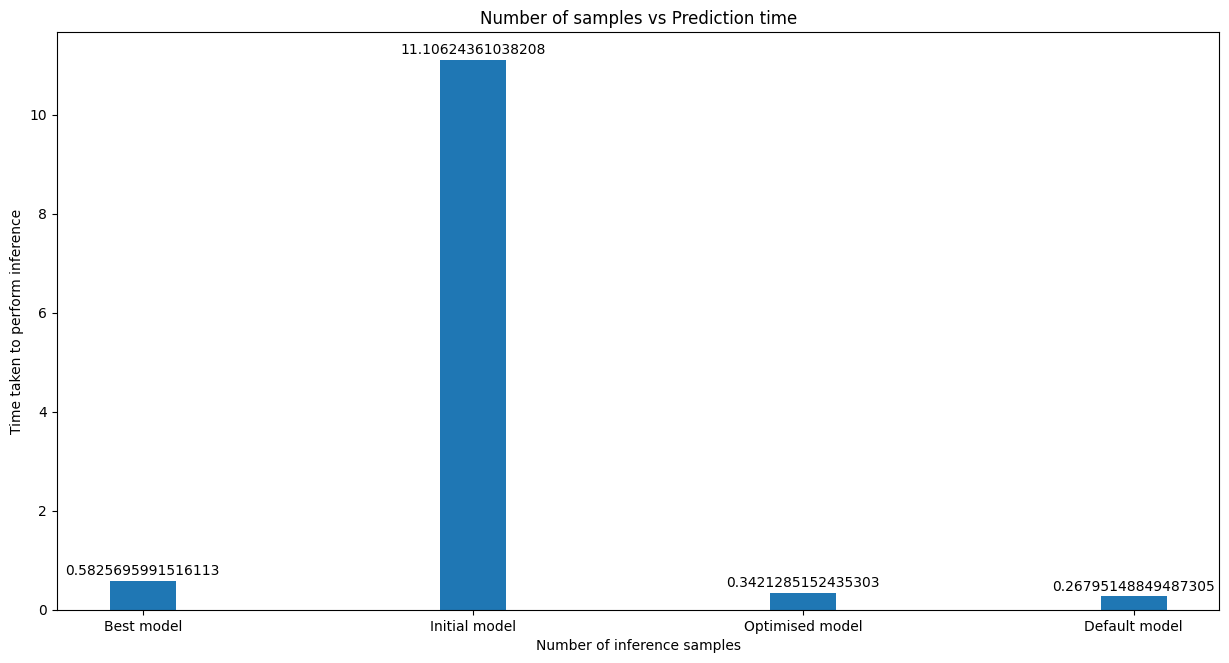

In [20]:
models = ['Best model', 'Initial model', 'Optimised model', 'Default model']
times = [best_inference_time, initial_inference_time, optimised_inference_time, default_inference_time]

fig, ax = plt.subplots(figsize=(15, 7.5))
plot = ax.bar(models, times, width=0.2)
ax.bar_label(plot, labels=times, padding=2)
plt.xlabel("Number of inference samples")
plt.ylabel("Time taken to perform inference")
plt.title("Number of samples vs Prediction time")
plt.show()

### Task 2.6.1.3 - Plot inference time vs train dataset size as the total number of samples increase for each of the 4 models

In [21]:
# Tenporary lists to reset the lists to their original values after the loop so that it is easier
# to run other individual cells that do not rely on these tunings
[temp_train_resnet, temp_train_vit, temp_train_labels] = [train_resnet_data, train_vit_data, train_labels]
[temp_validation_resnet, temp_validation_vit] = [validation_resnet_data, validation_vit_data]

data_sizes = [i for i in range(100, len(data) + 100, 100)]
initial_times_train, best_times_train, optimised_times_train, default_times_train = [], [], [], []

for i in data_sizes:
    train_resnet_data = resnet_data[:int(i * train_validation_split)]
    train_vit_data    = vit_data[:int(i * train_validation_split)]
    train_labels = data[:, 2][:int(i * train_validation_split)]

    validation_resnet_data = resnet_data[int(i * train_validation_split):i]
    validation_vit_data    = vit_data[int(i * train_validation_split):i]

    # Model initialisations
    initial   = KNN_initial(encoder='VIT', k=5, dist_metric='Manhattan')
    best      = KNN(encoder=best_params[1], k=best_params[0], dist_metric=best_params[2])
    optimised = KNN(encoder=optimised_params[1], k=optimised_params[0], dist_metric=optimised_params[2])
    default =  KNN_sk()
    default.fit(train_vit_data, train_labels)

    # Initial model
    inference_start = time()
    initial_preds = [initial.inference(i) for i in data[int(i * train_validation_split):i]]
    inference_end = time()
    initial_times_train.append(inference_end - inference_start)

    # Best model
    inference_start = time()
    best_preds = best.inference()
    inference_end = time()
    best_times_train.append(inference_end - inference_start)

    # Most optimised model
    inference_start = time()
    optimised_preds = optimised.inference()
    inference_end = time()
    optimised_times_train.append(inference_end - inference_start)

    # Default sklearn model
    inference_start = time()
    default_preds = default.predict(validation_vit_data)
    inference_end = time()
    default_times_train.append(inference_end - inference_start)

[train_resnet_data, train_vit_data, train_labels] = [temp_train_resnet, temp_train_vit, temp_train_labels]
[validation_resnet_data, validation_vit_data] = [temp_validation_resnet, temp_validation_vit]

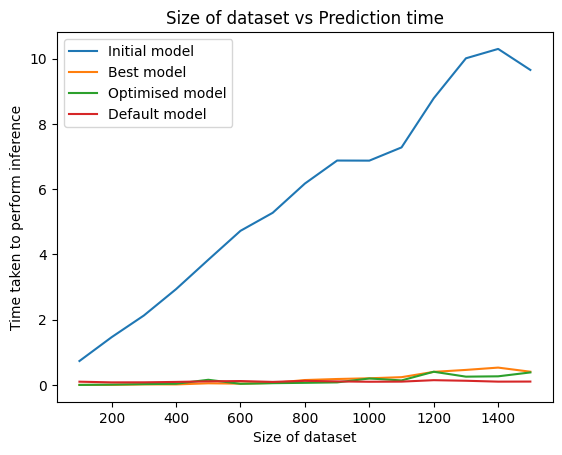

In [47]:
initial_plot,   =  plt.plot(data_sizes, initial_times_train)
best_plot,      =  plt.plot(data_sizes, best_times_train)
optimised_plot, =  plt.plot(data_sizes, optimised_times_train)
default_plot,   =  plt.plot(data_sizes, default_times_train)

plt.legend([initial_plot, best_plot, optimised_plot, default_plot], ["Initial model", "Best model", "Optimised model", "Default model"])
plt.xlabel("Size of dataset")
plt.ylabel("Time taken to perform inference")
plt.title("Size of dataset vs Prediction time")
plt.show()

# Task 3 - Decision Trees

#### Imports

In [23]:
import numpy as np                                              # For general array handling
import pandas as pd                                             # For loading, manipulating and printing the dataframe
import matplotlib.pyplot as plt                                 # Plotting the label distribution in the dataset
from sklearn import metrics as sm                               # To calculate the metrics of the model
from sklearn.model_selection import KFold                       # To perform splitting of the dataset as part of the K-Fold cross validation task
from sklearn.tree import DecisionTreeClassifier as DTC          # sklearn decision tree classifier class
from sklearn.preprocessing import MultiLabelBinarizer as MLB    # sklearn multi label binarizer class to return one hot encodings of labels

### Data preprocessing
#### Loading data and modifying the labels of the data according to the need
## Task 3.1 - Data Exploration

In [24]:
df = pd.read_csv('advertisement.csv')

# The labels are given as space-separated strings
# They are first split and then are sorted in alphabetical order
df['labels'] = [sorted(label.split()) for label in df['labels'].values]

df = df.sample(frac=1, ignore_index=True)   # Randomly shuffling the dataset such that the indices are not modified

### Dataset visualization

In [25]:
display(df)

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,64,Male,43868.077360,PhD,True,0,South Shannonshire,Scientist,127.228636,mobile,"[electronics, furniture]"
1,34,Male,54599.183571,High School,True,1,Austinview,HR,73.152606,novel,[books]
2,54,Female,41498.105485,Bachelor,True,2,Graychester,Artist,71.963014,perfume,"[beauty, books, clothing, furniture, home]"
3,64,Male,43973.550085,Master,True,1,South Erica,Salesman,82.244693,shirt,"[clothing, electronics, home]"
4,45,Female,41053.284516,Bachelor,True,1,New Scottville,HR,81.745685,mobile,"[clothing, electronics, furniture, home]"
...,...,...,...,...,...,...,...,...,...,...,...
995,20,Male,52420.801936,Bachelor,True,2,Jacksonville,Housewife,64.510070,gloves,"[clothing, electronics, furniture, home, sports]"
996,33,Male,38307.755250,Bachelor,True,3,Davidhaven,HR,98.956959,chips,"[books, food, home]"
997,21,Female,40825.926906,Bachelor,True,2,Port Georgeview,HR,85.205083,perfume,"[beauty, books, clothing, electronics, food]"
998,58,Female,53062.402456,High School,False,0,North Anthonyberg,Lawyer,73.696889,shoes,"[beauty, books, clothing, sports]"


### Data exploration and visualization
#### Obtaining the list of all individual labels and not as a list

In [26]:
labels = df['labels'].values

labels_list = []
for i in labels:
    for j in i:
        labels_list.append(j)

labels = np.array(labels_list)

#### Sorting the labels in descending order of their frequencies

In [27]:
label_freq = {}
for label in labels:
    if label in label_freq:
        label_freq[label] += 1
    else:
        label_freq[label] = 1
label_freq = dict(sorted(label_freq.items(), key=lambda x: x[1], reverse=True))

### Data visualization

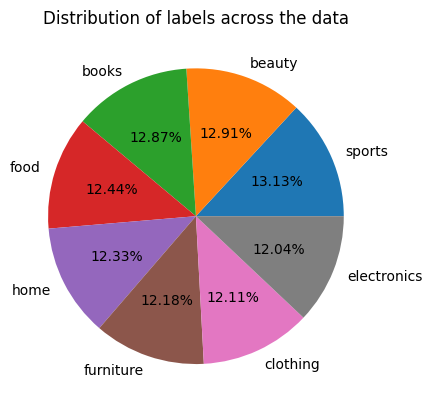

In [28]:
labels_list = list(label_freq.keys())
frequencies = list(label_freq.values())

plt.pie(frequencies, labels=labels_list, autopct='%1.2f%%') # Plotting the percentages of the labels in the dataset upto 2 decimal points of precision
plt.title('Distribution of labels across the data')
plt.show()

### Data featurization

#### Adding the one hot encodings of the features of the data points and removing the columns themselves
#### This is done only to categorical columns/features to convert them to numerical columns/features

In [29]:
categorical_features = ["gender", "education", "married", "city", "occupation", "most bought item"]

for category in categorical_features:
    one_hot = pd.get_dummies(df[category])  # One hot encoding is generated such that the record contains 1 in a column only if
                                            # the value of that feature of that record is same as the value of the column
    df = df.drop(category, axis=1)          # Dropping/removing this column from the dataset
    df = df.join(one_hot)                   # Adding all the columns from the one-hot encoding to the dataset at the end

# Shifting the labels to be at the end of the dataset
# Just for convenience and conventional purposes
labels = df['labels']
df = df.drop('labels', axis=1)
df = df.join(labels)

In [30]:
display(df)

,age,income,children,purchase_amount,Female,Male,Bachelor,High School,Master,PhD,...,mobile,monitor,novel,pants,perfume,shirt,shoes,sofa,table,labels
0,64,43868.077360,0,127.228636,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,"[electronics, furniture]"
1,34,54599.183571,1,73.152606,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,[books]
2,54,41498.105485,2,71.963014,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,"[beauty, books, clothing, furniture, home]"
3,64,43973.550085,1,82.244693,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,"[clothing, electronics, home]"
4,45,41053.284516,1,81.745685,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,"[clothing, electronics, furniture, home]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20,52420.801936,2,64.510070,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[clothing, electronics, furniture, home, sports]"
996,33,38307.755250,3,98.956959,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[books, food, home]"
997,21,40825.926906,2,85.205083,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,"[beauty, books, clothing, electronics, food]"
998,58,53062.402456,0,73.696889,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,"[beauty, books, clothing, sports]"


#### Data featurization for the multi output and powerset classifiers

In [31]:
# List of all unique features
unique_labels = sorted(list(set(labels_list)))

# Power set of all unique features
power_set=[()]
for label in unique_labels:
    temp_list = []
    for sub_set in power_set:
        temp_list += [sorted(list(sub_set) + [label])]      # Sorting is done to ensure that the labels are in alphabetical order
    temp_list = [tuple(i) for i in temp_list]               # The lists are converted to tuples so as to simplify the conversion of labels to one-hot encodings
                                                            # by the Multi Label Binarizer class
    power_set += temp_list
power_set = sorted(power_set, key=lambda x: (len(x), x))    # Sorted by length of the subset and then the elements of the subset. This is done to ensure
                                                            # that the power set is created similar to the convention of how we write a power set

#### One-hot encoding of the labels for the Multi Output formulation decision tree classifier

In [32]:
multi_output_binarizer = MLB(classes=unique_labels) # Classes parameter specifies the order in which each of the features of the labels are to be placed while performing one-hot encoding

# This function converts each of the labels to one-hot encodings based on the already initialised classes attribute
multi_output_one_hot = multi_output_binarizer.fit_transform(df['labels'].values)

#### One-hot encoding of the labels for the Power Set formulation decision tree classifier

In [33]:
# The MLB class expects a list of lists where each element must be hashable. Hence, the labels are converted to tuples and also
# sorted to ensure that the labels are in alphabetical order just to preserve the convention of order of power sets
power_set_labels = [[tuple(sorted(i))] for i in df['labels'].values]

# The previously initialised power set is used to specify the order in which each tuple of labels are to be placed while performing one-hot encoding
power_set_binarizer = MLB(classes=power_set)

# This function converts each tuple of labels to one-hot encodings based on the already initialised classes attribute
power_set_one_hot = power_set_binarizer.fit_transform(power_set_labels)

### Train Validation splitting of the dataset

In [34]:
X_data = np.array(df.iloc[:])[:, :-1]           # df.iloc[:] is used to extract all rows of the dataset after which we consider all columns
                                                # except the last column which contains the labels

train_validation_split = int(0.8 * len(X_data)) # 80-20 train validation split of the dataset

X_train = X_data[:train_validation_split]       # First 80% of the shuffled dataset
X_validation = X_data[train_validation_split:]  # Last  20% of the shuffled dataset

Y_train_multi_output = multi_output_one_hot[:train_validation_split]        # First 80% of the multi output one hot encoded labels
Y_validation_multi_output = multi_output_one_hot[train_validation_split:]   # Last  20% of the multi output one hot encoded labels

Y_train_power_set = power_set_one_hot[:train_validation_split]              # First 80% of the power set one hot encoded labels
Y_validation_power_set = power_set_one_hot[train_validation_split:]         # Last  20% of the power set one hot encoded labels

# Temporary lists to keep track of these splits later onso that they can be reset to their original values
[temp_X_train, temp_X_validation] = [X_train, X_validation]
[temp_Y_train_multi_output, temp_Y_validation_multi_output] = [Y_train_multi_output, Y_validation_multi_output]
[temp_Y_train_power_set, temp_Y_validation_power_set] = [Y_train_power_set, Y_validation_power_set]

## Task 3.3 - MultiLabel Classification
### Task 3.3.1.2 - Multi Output Formulation

In [35]:
class DTC_Multi_Output():
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.DTC = DTC(max_depth=max_depth, max_features=max_features, criterion=criterion)
        
        self.X_train = X_train
        self.Y_train = Y_train_multi_output
        
        self.X_validation = X_validation
        self.Y_validation = Y_validation_multi_output

        self.__train()

    # Training method
    def __train(self):
        self.DTC.fit(self.X_train, self.Y_train)

    # Validation method
    def inference(self):
        return self.DTC.predict(X_validation)

#### Prediction of labels using the multi output formulation decision tree classifier

In [36]:
multi_output_DTC = DTC_Multi_Output()
multi_output_inference = multi_output_DTC.inference()

Y_validation_multi_output_numerical = []
multi_output_inference_numerical    = []

# Converting the one-hot encoded labels to their numerical values so that they can be passed to the sklearn confusion matrix metric
# This conversion is just a simple binary to decimal conversion

for i in Y_validation_multi_output:
    num, power = 0, 0
    for j in i[::-1]:
        num += j * (2 ** power)
    Y_validation_multi_output_numerical.append(num)

for i in multi_output_inference:
    num, power = 0, 0
    for j in i[::-1]:
        num += j * (2 ** power)
    multi_output_inference_numerical.append(num)

#### Multi output formulation classifier metrics

In [37]:
accuracy          = sm.accuracy_score( Y_validation_multi_output, multi_output_inference)
macro_f1_score    = sm.f1_score(       Y_validation_multi_output, multi_output_inference, average='macro')
micro_f1_score    = sm.f1_score(       Y_validation_multi_output, multi_output_inference, average='micro')
weighted_f1_score = sm.f1_score(       Y_validation_multi_output, multi_output_inference, average='weighted')
precision         = sm.precision_score(Y_validation_multi_output, multi_output_inference, average='macro', zero_division=0)
recall            = sm.recall_score(   Y_validation_multi_output, multi_output_inference, average='macro', zero_division=0)

metrics_values = [accuracy, macro_f1_score, micro_f1_score, weighted_f1_score, precision, recall]
printMetrics(metrics_values)

matrix = sm.confusion_matrix(Y_validation_multi_output_numerical, multi_output_inference_numerical)
print(matrix)
print(matrix.shape)

Metric,Value
Accuracy,0.035000
Macro F-1 score,0.503111
Micro F-1 score,0.504171
Weighted F-1 score,0.503906
Precision,0.540762
Recall,0.470916


[[ 3  5 13  1  2  0  0]
 [ 8 24 12  6  3  1  0]
 [ 9 29 22  8  1  0  0]
 [ 4 11  9  6  1  1  0]
 [ 5 11  1  0  0  1  0]
 [ 0  1  0  0  0  0  0]
 [ 1  1  0  0  0  0  0]]
(7, 7)


### Task 3.3.1.1 - Power Set Formulation

In [38]:
class DTC_Power_Set():
    def __init__(self, max_depth=None, max_features=None, criterion='gini'):
        self.DTC = DTC(max_depth=max_depth, max_features=max_features, criterion=criterion)
        
        self.X_train = X_train
        self.Y_train = Y_train_power_set
        
        self.X_validation = X_validation
        self.Y_validation = Y_validation_power_set

        self.__train()

    # Training method
    def __train(self):
        self.DTC.fit(self.X_train, self.Y_train)

    # Validation method
    def inference(self):
        return self.DTC.predict(X_validation)

#### Prediction of labels using the power set formulation decision tree classifier

In [39]:
power_set_DTC = DTC_Power_Set()
power_set_inference = power_set_DTC.inference()

Y_validation_power_set_numerical = []
power_set_inference_numerical    = []

# Converting the one-hot encoded labels to their numerical values so that they can be passed to the sklearn confusion matrix metric
# This conversion is just finding the index where the encoding contains a 1

for i in Y_validation_power_set:
    for j in range(len(i)):
        if i[j]:
            Y_validation_power_set_numerical.append(j + 1)    

for i in power_set_inference:
    for j in range(len(i)):
        if i[j]:
            power_set_inference_numerical.append(j + 1)

#### Power set formulation classifier metrics

In [40]:
accuracy          = sm.accuracy_score( Y_validation_power_set, power_set_inference)
macro_f1_score    = sm.f1_score(       Y_validation_power_set, power_set_inference, average='macro',    zero_division=0)
micro_f1_score    = sm.f1_score(       Y_validation_power_set, power_set_inference, average='micro',    zero_division=0)
weighted_f1_score = sm.f1_score(       Y_validation_power_set, power_set_inference, average='weighted', zero_division=0)
precision         = sm.precision_score(Y_validation_power_set, power_set_inference, average='macro',    zero_division=0)
recall            = sm.recall_score(   Y_validation_power_set, power_set_inference, average='macro',    zero_division=0)

metrics_values = [accuracy, macro_f1_score, micro_f1_score, weighted_f1_score, precision, recall]
printMetrics(metrics_values)

matrix = sm.confusion_matrix(Y_validation_power_set_numerical, power_set_inference_numerical)
print(matrix)
print(matrix.shape)

Metric,Value
Accuracy,0.035000
Macro F-1 score,0.007574
Micro F-1 score,0.035000
Weighted F-1 score,0.032000
Precision,0.008371
Recall,0.008138


[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(148, 148)


## Task 3.4 - Hyperparameter Tuning

In [41]:
criteria = ['gini', 'entropy']
max_depths = [3, 5, 10, 20, 30]
max_features = [3, 5, 7, 9, 11]

#### Tasks 3.4.1.1 and 3.4.1.2 - Multi Output formulation classifier metrics and 3 best performing hyperparameter triplets
## Assumption in tiebreaking for best hyperparamters:
- First sorted in decreasing order of `Macro f1 score`, then `Micro f1 score`, then `Weighted f1 score` and finally `Accuracy`

In [42]:
param_list_multi_output = []
multi_output_metrics = []

for criterion in criteria:
    for max_depth in max_depths:
        for max_feature in max_features:
            param_multi_output_DTC = DTC_Multi_Output(max_depth=max_depth, max_features=max_feature, criterion=criterion)
            param_multi_output_inference = param_multi_output_DTC.inference()

            # Converting the encodings to numerical form for calculating the confusion matrix
            param_multi_output_inference_numerical = []
            for i in param_multi_output_inference:
                num, power = 0, 0
                for j in i[::-1]:
                    num += j * (2 ** power)
                param_multi_output_inference_numerical.append(num)

            accuracy           =   sm.accuracy_score(  Y_validation_multi_output, param_multi_output_inference)
            f1_score_macro     =   sm.f1_score(        Y_validation_multi_output, param_multi_output_inference, average='macro')
            f1_score_micro     =   sm.f1_score(        Y_validation_multi_output, param_multi_output_inference, average='micro')
            f1_score_weighted  =   sm.f1_score(        Y_validation_multi_output, param_multi_output_inference, average='weighted')
            precision          =   sm.precision_score( Y_validation_multi_output, param_multi_output_inference, average='macro', zero_division=0)
            recall             =   sm.recall_score(    Y_validation_multi_output, param_multi_output_inference, average='macro', zero_division=0)
            matrix             =   sm.confusion_matrix(Y_validation_multi_output_numerical, param_multi_output_inference_numerical)

            param_list_multi_output.append((criterion, max_depth, max_feature, f1_score_macro, f1_score_micro, f1_score_weighted, accuracy))
            multi_output_metrics.append([criterion, max_depth, max_feature, accuracy, f1_score_macro, f1_score_micro, f1_score_weighted, precision, recall, matrix])

# Sorting the classifier based on descending order of macro f1 score, then micro f1 socre, then weighted f1 score and then accuracy
param_list_multi_output = sorted(param_list_multi_output, key=lambda x: tuple([x[3], x[4], x[5], x[6]]), reverse=True)
print(param_list_multi_output[:3])

for i in multi_output_metrics:
    metrics_values = i[:-1]
    printMetrics(metrics_values)
    print(i[-1])
    print(i[-1].shape)

[('gini', 30, 9, 0.25196106849959504, 0.26717557251908397, 0.2572177577874911, 0.01), ('gini', 30, 7, 0.2519229573047417, 0.25260416666666663, 0.2518395119440192, 0.02), ('gini', 20, 11, 0.23948041510298312, 0.24423337856173674, 0.23972844182692504, 0.01)]


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [54  0  0  0  0  0  0  0]
 [69  0  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,5
Weighted F-1 score,0.015000
Precision,0.056122
Recall,0.073456


[[ 0  0  0  0  0  0  0  0]
 [21  3  0  0  0  0  0  0]
 [44 10  0  0  0  0  0  0]
 [65  4  0  0  0  0  0  0]
 [31  1  0  0  0  0  0  0]
 [14  4  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,7
Weighted F-1 score,0.025000
Precision,0.059017
Recall,0.063758


[[ 0  0  0  0  0  0  0  0]
 [19  5  0  0  0  0  0  0]
 [51  3  0  0  0  0  0  0]
 [62  7  0  0  0  0  0  0]
 [30  2  0  0  0  0  0  0]
 [16  2  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,9
Weighted F-1 score,0.005000
Precision,0.021341
Recall,0.023973


[[ 0  0  0  0  0  0  0  0]
 [23  1  0  0  0  0  0  0]
 [52  2  0  0  0  0  0  0]
 [68  1  0  0  0  0  0  0]
 [30  2  0  0  0  0  0  0]
 [17  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,11
Weighted F-1 score,0.010000
Precision,0.032353
Recall,0.037225


[[ 0  0  0  0  0  0  0  0]
 [22  2  0  0  0  0  0  0]
 [53  1  0  0  0  0  0  0]
 [66  2  0  0  1  0  0  0]
 [29  3  0  0  0  0  0  0]
 [16  2  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [54  0  0  0  0  0  0  0]
 [69  0  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.027108
Recall,0.030717


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [52  2  0  0  0  0  0  0]
 [67  2  0  0  0  0  0  0]
 [28  4  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [54  0  0  0  0  0  0  0]
 [69  0  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.032920
Recall,0.036975


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [53  0  1  0  0  0  0  0]
 [63  0  6  0  0  0  0  0]
 [30  0  2  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,11
Weighted F-1 score,0.005000
Precision,0.068063
Recall,0.074313


[[ 0  0  0  0  0  0  0  0]
 [20  4  0  0  0  0  0  0]
 [47  6  0  0  1  0  0  0]
 [57 10  0  2  0  0  0  0]
 [30  1  0  0  1  0  0  0]
 [14  3  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,3
Weighted F-1 score,0.005000
Precision,0.024289
Recall,0.027165


[[ 0  0  0  0  0  0  0  0]
 [23  1  0  0  0  0  0  0]
 [52  2  0  0  0  0  0  0]
 [67  1  0  0  0  1  0  0]
 [30  2  0  0  0  0  0  0]
 [17  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,5
Weighted F-1 score,0.010000
Precision,0.032353
Recall,0.037415


[[ 0  0  0  0  0  0  0  0]
 [22  2  0  0  0  0  0  0]
 [51  3  0  0  0  0  0  0]
 [64  5  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.028902
Recall,0.030100


[[ 0  0  0  0  0  0  0  0]
 [23  0  1  0  0  0  0  0]
 [53  0  1  0  0  0  0  0]
 [66  0  1  0  0  0  1  1]
 [31  0  1  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.003333
Recall,0.003454


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [53  0  1  0  0  0  0  0]
 [69  0  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,11
Weighted F-1 score,0.025000
Precision,0.082211
Recall,0.091803


[[ 0  0  0  0  0  0  0  0]
 [20  4  0  0  0  0  0  0]
 [47  5  1  0  0  1  0  0]
 [63  6  0  0  0  0  0  0]
 [25  7  0  0  0  0  0  0]
 [16  1  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,3
Weighted F-1 score,0.015000
Precision,0.104713
Recall,0.104596


[[ 0  0  0  0  0  0  0  0]
 [20  3  0  0  1  0  0  0]
 [50  1  1  0  1  0  1  0]
 [58  5  1  3  2  0  0  0]
 [27  4  0  1  0  0  0  0]
 [16  1  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,5
Weighted F-1 score,0.010000
Precision,0.170062
Recall,0.177650


[[ 0  0  0  0  0  0  0  0]
 [17  2  3  2  0  0  0  0]
 [39  6  3  4  2  0  0  0]
 [48  7 11  0  2  1  0  0]
 [23  2  6  0  0  1  0  0]
 [13  2  1  1  0  1  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,7
Weighted F-1 score,0.015000
Precision,0.097566
Recall,0.102804


[[ 0  0  0  0  0  0  0  0]
 [18  2  3  0  1  0  0  0]
 [43  3  6  1  0  0  1  0]
 [56  9  2  1  0  1  0  0]
 [30  2  0  0  0  0  0  0]
 [17  0  0  0  0  1  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,9
Weighted F-1 score,0.010000
Precision,0.150389
Recall,0.156863


[[ 0  0  0  0  0  0  0  0]
 [19  2  2  0  1  0  0  0]
 [39 12  1  1  1  0  0  0]
 [53  7  7  0  1  0  1  0]
 [21  7  4  0  0  0  0  0]
 [12  3  3  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,11
Weighted F-1 score,0.010000
Precision,0.239480
Recall,0.244233


[[ 0  0  0  0  0  0  0  0]
 [16  3  0  3  2  0  0  0]
 [30 16  4  1  2  1  0  0]
 [39  9 11  7  0  3  0  0]
 [23  4  3  2  0  0  0  0]
 [ 9  6  0  1  2  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,3
Weighted F-1 score,0.025000
Precision,0.167361
Recall,0.174436


[[ 0  0  0  0  0  0  0  0]
 [17  5  1  0  1  0  0  0]
 [42  5  4  2  0  1  0  0]
 [55  8  1  2  1  2  0  0]
 [28  1  1  1  1  0  0  0]
 [13  1  1  3  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,5
Weighted F-1 score,0.015000
Precision,0.114064
Recall,0.118936


[[ 0  0  0  0  0  0  0  0]
 [20  2  2  0  0  0  0  0]
 [47  5  0  2  0  0  0  0]
 [60  5  1  2  0  0  0  1]
 [24  4  0  2  1  0  1  0]
 [13  5  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,7
Weighted F-1 score,0.020000
Precision,0.251923
Recall,0.252604


[[ 0  0  0  0  0  0  0  0]
 [14  6  0  3  0  1  0  0]
 [35  8  3  2  1  5  0  0]
 [40 10  8  7  1  3  0  0]
 [20  2  3  4  1  0  2  0]
 [ 8  6  2  2  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,9
Weighted F-1 score,0.010000
Precision,0.251961
Recall,0.267176


[[ 0  0  0  0  0  0  0  0]
 [15  3  2  4  0  0  0  0]
 [26 10  9  3  3  2  1  0]
 [45  9  7  2  5  1  0  0]
 [17  4  1  6  3  1  0  0]
 [ 6  2  5  2  3  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,11
Weighted F-1 score,0.020000
Precision,0.237298
Recall,0.239680


[[ 0  0  0  0  0  0  0  0]
 [15  4  2  1  1  1  0  0]
 [34  6  8  5  1  0  0  0]
 [42  7  6  6  2  6  0  0]
 [22  2  4  2  2  0  0  0]
 [15  0  1  1  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [54  0  0  0  0  0  0  0]
 [69  0  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [54  0  0  0  0  0  0  0]
 [69  0  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.016892
Recall,0.017182


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [51  3  0  0  0  0  0  0]
 [68  1  0  0  0  0  0  0]
 [31  1  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.007463
Recall,0.006897


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [53  0  1  0  0  0  0  0]
 [68  1  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,11
Weighted F-1 score,0.010000
Precision,0.035686
Recall,0.040404


[[ 0  0  0  0  0  0  0  0]
 [22  2  0  0  0  0  0  0]
 [53  1  0  0  0  0  0  0]
 [65  3  0  0  0  0  1  0]
 [29  3  0  0  0  0  0  0]
 [16  2  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,3
Weighted F-1 score,0.010000
Precision,0.032353
Recall,0.037415


[[ 0  0  0  0  0  0  0  0]
 [22  2  0  0  0  0  0  0]
 [53  1  0  0  0  0  0  0]
 [66  3  0  0  0  0  0  0]
 [29  3  0  0  0  0  0  0]
 [16  2  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.003676
Recall,0.003454


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [54  0  0  0  0  0  0  0]
 [68  0  1  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,7
Weighted F-1 score,0.005000
Precision,0.054407
Recall,0.062914


[[ 0  0  0  0  0  0  0  0]
 [23  1  0  0  0  0  0  0]
 [53  1  0  0  0  0  0  0]
 [60  4  0  3  2  0  0  0]
 [29  3  0  0  0  0  0  0]
 [17  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [54  0  0  0  0  0  0  0]
 [69  0  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,11
Weighted F-1 score,0.010000
Precision,0.077738
Recall,0.085950


[[ 0  0  0  0  0  0  0  0]
 [22  2  0  0  0  0  0  0]
 [44  8  2  0  0  0  0  0]
 [61  8  0  0  0  0  0  0]
 [30  2  0  0  0  0  0  0]
 [16  1  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,3
Weighted F-1 score,0.025000
Precision,0.083726
Recall,0.088525


[[ 0  0  0  0  0  0  0  0]
 [19  5  0  0  0  0  0  0]
 [47  5  1  0  1  0  0  0]
 [60  6  3  0  0  0  0  0]
 [30  2  0  0  0  0  0  0]
 [17  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,5
Weighted F-1 score,0.005000
Precision,0.038688
Recall,0.039933


[[ 0  0  0  0  0  0  0  0]
 [23  0  0  0  0  1  0  0]
 [52  0  1  1  0  0  0  0]
 [65  0  1  3  0  0  0  0]
 [31  0  1  0  0  0  0  0]
 [17  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[ 0  0  0  0  0  0  0  0]
 [24  0  0  0  0  0  0  0]
 [54  0  0  0  0  0  0  0]
 [69  0  0  0  0  0  0  0]
 [32  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.044954
Recall,0.046205


[[ 0  0  0  0  0  0  0  0]
 [23  0  1  0  0  0  0  0]
 [51  1  0  1  0  0  1  0]
 [65  1  2  1  0  0  0  0]
 [27  1  4  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,11
Weighted F-1 score,0.010000
Precision,0.070054
Recall,0.071895


[[ 0  0  0  0  0  0  0  0]
 [22  2  0  0  0  0  0  0]
 [48  1  2  2  0  1  0  0]
 [63  2  3  1  0  0  0  0]
 [31  0  0  1  0  0  0  0]
 [16  2  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.069359
Recall,0.073365


[[ 0  0  0  0  0  0  0  0]
 [23  0  1  0  0  0  0  0]
 [47  3  1  1  2  0  0  0]
 [64  2  2  0  0  0  1  0]
 [28  1  1  0  1  1  0  0]
 [15  1  0  1  1  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,5
Weighted F-1 score,0.015000
Precision,0.044736
Recall,0.046434


[[ 0  0  0  0  0  0  0  0]
 [21  3  0  0  0  0  0  0]
 [52  2  0  0  0  0  0  0]
 [61  6  1  1  0  0  0  0]
 [28  2  0  1  1  0  0  0]
 [17  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.119758
Recall,0.128550


[[ 0  0  0  0  0  0  0  0]
 [20  0  2  2  0  0  0  0]
 [42  1  5  4  0  2  0  0]
 [58  0  5  2  4  0  0  0]
 [28  1  1  1  1  0  0  0]
 [16  0  1  1  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,9
Weighted F-1 score,0.005000
Precision,0.151861
Recall,0.151786


[[ 0  0  0  0  0  0  0  0]
 [20  1  2  1  0  0  0  0]
 [40  6  3  2  3  0  0  0]
 [53  4  4  6  2  0  0  0]
 [25  2  4  0  1  0  0  0]
 [16  1  0  0  1  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,11
Weighted F-1 score,0.010000
Precision,0.140353
Recall,0.145062


[[ 0  0  0  0  0  0  0  0]
 [21  2  1  0  0  0  0  0]
 [44  5  3  2  0  0  0  0]
 [54  6  7  0  0  2  0  0]
 [24  4  2  0  1  1  0  0]
 [16  1  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,3
Weighted F-1 score,0.015000
Precision,0.117256
Recall,0.119309


[[ 0  0  0  0  0  0  0  0]
 [18  3  1  1  1  0  0  0]
 [49  3  1  0  1  0  0  0]
 [58  7  1  1  2  0  0  0]
 [29  1  0  0  2  0  0  0]
 [15  1  0  0  1  1  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.092158
Recall,0.097179


[[ 0  0  0  0  0  0  0  0]
 [23  0  0  1  0  0  0  0]
 [49  0  1  2  1  0  1  0]
 [61  0  1  2  4  1  0  0]
 [28  0  3  1  0  0  0  0]
 [17  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,7
Weighted F-1 score,0.005000
Precision,0.124275
Recall,0.125960


[[ 0  0  0  0  0  0  0  0]
 [20  1  3  0  0  0  0  0]
 [48  3  1  1  1  0  0  0]
 [60  3  1  1  2  2  0  0]
 [25  3  2  0  1  1  0  0]
 [14  0  3  0  1  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,9
Weighted F-1 score,0.015000
Precision,0.151203
Recall,0.162896


[[ 0  0  0  0  0  0  0  0]
 [22  1  1  0  0  0  0  0]
 [39  4  8  2  1  0  0  0]
 [54  2 11  0  0  2  0  0]
 [25  2  5  0  0  0  0  0]
 [14  1  3  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0]]
(8, 8)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,11
Weighted F-1 score,0.015000
Precision,0.224382
Recall,0.229420


[[ 0  0  0  0  0  0  0  0]
 [19  1  2  0  1  0  1  0]
 [37  3  2  6  3  3  0  0]
 [52  3  2  8  2  1  1  0]
 [17  7  2  3  2  1  0  0]
 [14  0  1  2  1  0  0  0]
 [ 1  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0]]
(8, 8)


#### Tasks 3.4.1.1 and 3.4.1.2 - Power Set formulation classifier metrics and 3 best performing hyperparameter triplets
## Assumption in tiebreaking for best hyperparamters:
- First sorted in decreasing order of `Macro f1 score`, then `Micro f1 score`, then `Weighted f1 score` and finally `Accuracy`

In [43]:
param_list_power_set = []
power_set_metrics = []

for criterion in criteria:
    for max_depth in max_depths:
        for max_feature in max_features:
            param_power_set_DTC = DTC_Power_Set(max_depth=max_depth, max_features=max_feature, criterion=criterion)
            param_power_set_inference = param_power_set_DTC.inference()

            # Converting the encodings to numerical form for calculating the confusion matrix
            param_power_set_inference_numerical = []
            for i in param_power_set_inference:
                num, power = 0, 0
                for j in i[::-1]:
                    num += j * (2 ** power)
                param_power_set_inference_numerical.append(num)

            accuracy            =   sm.accuracy_score(  Y_validation_power_set, param_power_set_inference)
            f1_score_macro      =   sm.f1_score(        Y_validation_power_set, param_power_set_inference, average='macro',    zero_division=0)
            f1_score_micro      =   sm.f1_score(        Y_validation_power_set, param_power_set_inference, average='micro',    zero_division=0)
            f1_score_weighted   =   sm.f1_score(        Y_validation_power_set, param_power_set_inference, average='weighted', zero_division=0)
            precision           =   sm.precision_score( Y_validation_power_set, param_power_set_inference, average='macro',    zero_division=0)
            recall              =   sm.recall_score(    Y_validation_power_set, param_power_set_inference, average='macro',    zero_division=0)
            matrix              =   sm.confusion_matrix(Y_validation_power_set_numerical, param_power_set_inference_numerical)

            param_list_power_set.append((criterion, max_depth, max_feature, f1_score_macro, f1_score_micro, f1_score_weighted, accuracy))
            power_set_metrics.append([criterion, max_depth, max_feature, accuracy, f1_score_macro, f1_score_micro, f1_score_weighted, precision, recall, matrix])

# Sorting the classifier based on descending order of macro f1 score, then micro f1 socre, then weighted f1 score and then accuracy
param_list_power_set = sorted(param_list_power_set, key=lambda x: tuple([x[3], x[4], x[5], x[6]]), reverse=True)
print(param_list_power_set[:3])

for i in power_set_metrics:
    metrics_values = i[:-1]
    printMetrics(metrics_values)
    print(i[-1])
    print(i[-1].shape)

[('gini', 30, 5, 0.009375, 0.02247191011235955, 0.012, 0.015), ('entropy', 30, 11, 0.005208333333333333, 0.03125, 0.020416666666666666, 0.02), ('entropy', 20, 9, 0.004557291666666666, 0.016194331983805668, 0.011666666666666665, 0.01)]


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,3
Micro F-1 score,11
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,5
Micro F-1 score,11
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,9
Weighted F-1 score,0.005000
Precision,0.001302
Recall,0.009434


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,10
Micro F-1 score,11
Weighted F-1 score,0.010000
Precision,0.003720
Recall,0.018519


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,20
Micro F-1 score,11
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,3
Weighted F-1 score,0.005000
Precision,0.001302
Recall,0.009259


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,5
Weighted F-1 score,0.015000
Precision,0.009375
Recall,0.022472


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 2 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,gini
Macro F-1 score,30
Micro F-1 score,11
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,3
Micro F-1 score,11
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,5
Micro F-1 score,11
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,9
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,10
Micro F-1 score,11
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(118, 118)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,3
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 2 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,5
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,7
Weighted F-1 score,0.000000
Precision,0.000000
Recall,0.000000


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,9
Weighted F-1 score,0.010000
Precision,0.004557
Recall,0.016194


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,20
Micro F-1 score,11
Weighted F-1 score,0.010000
Precision,0.003314
Recall,0.017167


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,3
Weighted F-1 score,0.010000
Precision,0.001420
Recall,0.016807


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,5
Weighted F-1 score,0.010000
Precision,0.003516
Recall,0.015873


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,7
Weighted F-1 score,0.010000
Precision,0.004167
Recall,0.014981


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,9
Weighted F-1 score,0.010000
Precision,0.002604
Recall,0.013605


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [2 2 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


Metric,Value
Accuracy,entropy
Macro F-1 score,30
Micro F-1 score,11
Weighted F-1 score,0.020000
Precision,0.005208
Recall,0.031250


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 1 0 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
(119, 119)


#### Task 3.4.1.3 - K-fold cross validation of Multi Output classifier

In [44]:
k = 10
k_fold_multi_output_split_indices = KFold(n_splits=k).split(X_data) # List of tuples indicating which indices fall into train and validation splits
multi_output_params = param_list_multi_output[0]                    # Best hyperparameters for the Multi Output classifier
multi_output_metrics = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])     # List to store the average of the metrics obtained in each fold of the validation process

for i in k_fold_multi_output_split_indices:
    # Split of features
    X_train      = X_data[i[0]]
    X_validation = X_data[i[1]]

    # Split of labels
    Y_train_multi_output      = multi_output_one_hot[i[0]]
    Y_validation_multi_output = multi_output_one_hot[i[1]]

    # Classifier initialised using the best hyperparamteres and inference is performed
    best_multi_output_DTC         = DTC_Multi_Output(max_depth=multi_output_params[2], max_features=multi_output_params[1], criterion=multi_output_params[0])
    k_fold_multi_output_inference = best_multi_output_DTC.inference()
    
    accuracy            =   sm.accuracy_score(  Y_validation_multi_output, k_fold_multi_output_inference)
    f1_score_macro      =   sm.f1_score(        Y_validation_multi_output, k_fold_multi_output_inference, average='macro',    zero_division=0)
    f1_score_micro      =   sm.f1_score(        Y_validation_multi_output, k_fold_multi_output_inference, average='micro',    zero_division=0)
    f1_score_weighted   =   sm.f1_score(        Y_validation_multi_output, k_fold_multi_output_inference, average='weighted', zero_division=0)
    precision           =   sm.precision_score( Y_validation_multi_output, k_fold_multi_output_inference, average='macro',    zero_division=0)
    recall              =   sm.recall_score(    Y_validation_multi_output, k_fold_multi_output_inference, average='macro',    zero_division=0)

    multi_output_metrics += np.array([accuracy, f1_score_macro, f1_score_micro, f1_score_weighted, precision, recall])

multi_output_metrics /= k           # List containing the average of the metrics obtained in each fold of the validation process
printMetrics(multi_output_metrics)

# Resetting the lists to their original values
[X_train, X_validation] = [temp_X_train, temp_X_validation]
[Y_train_multi_output, Y_validation_multi_output] = [temp_Y_train_multi_output, temp_Y_validation_multi_output]

Metric,Value
Accuracy,0.012000
Macro F-1 score,0.129950
Micro F-1 score,0.139003
Weighted F-1 score,0.129742
Precision,0.496607
Recall,0.077336


#### Task 3.4.1.3 - K-fold cross validation of Power Set classifier

In [51]:
k = 10
k_fold_power_set_split_indices = KFold(n_splits=k).split(X_data)    # List of tuples indicating which indices fall into train and validation splits
power_set_params = param_list_power_set[0]                          # Best hyperparameters for the Multi Output classifier
power_set_metrics = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])        # List to store the average of the metrics obtained in each fold of the validation process

for i in k_fold_power_set_split_indices:
    # Split of features
    X_train      = X_data[i[0]]
    X_validation = X_data[i[1]]

    # Split of labels
    Y_train_power_set      = power_set_one_hot[i[0]]
    Y_validation_power_set = power_set_one_hot[i[1]]

    # Classifier initialised using the best hyperparamteres and inference is performed
    best_power_set_DTC = DTC_Power_Set(max_depth=power_set_params[2], max_features=power_set_params[1], criterion=power_set_params[0])
    k_fold_power_set_inference = best_power_set_DTC.inference()

    accuracy            =   sm.accuracy_score(  Y_validation_power_set, k_fold_power_set_inference)
    f1_score_macro      =   sm.f1_score(        Y_validation_power_set, k_fold_power_set_inference, average='macro',    zero_division=0)
    f1_score_micro      =   sm.f1_score(        Y_validation_power_set, k_fold_power_set_inference, average='micro',    zero_division=0)
    f1_score_weighted   =   sm.f1_score(        Y_validation_power_set, k_fold_power_set_inference, average='weighted', zero_division=0)
    precision           =   sm.precision_score( Y_validation_power_set, k_fold_power_set_inference, average='macro',    zero_division=0)
    recall              =   sm.recall_score(    Y_validation_power_set, k_fold_power_set_inference, average='macro',    zero_division=0)

    power_set_metrics += np.array([accuracy, f1_score_macro, f1_score_micro, f1_score_weighted, precision, recall])

power_set_metrics /= k          # List containing the average of the metrics obtained in each fold of the validation process
printMetrics(power_set_metrics)

# Resetting the lists to their original values
[X_train, X_validation] = [temp_X_train, temp_X_validation]
[Y_train_power_set, Y_validation_power_set] = [temp_Y_train_power_set, temp_Y_validation_power_set]

Metric,Value
Accuracy,0.001000
Macro F-1 score,0.000195
Micro F-1 score,0.001980
Weighted F-1 score,0.001500
Precision,0.000391
Recall,0.000130
